# Customising a mock survey

In this example, we demonstrate how to put in a custom survey specification in terms of frequency range and sky area.

In [1]:
import numpy as np
from meer21cm import Specification, MockSimulation
from meer21cm.util import create_wcs_with_range
from meer21cm.plot import plot_map
from meer21cm.util import redshift_to_freq
import meer21cm
import matplotlib.pyplot as plt
from astropy.wcs import WCS
data_dir = meer21cm.__file__.rsplit("/", 1)[0] + "/data/"


/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


## Default

By default, if you create a default `Specfication` (which is also the base class for everything else such as `PowerSpectrum` or `MockSimulation`), the specs follow the MeerKLASS L-band deep survey:

In [2]:
sp = Specification()

In [3]:
sp.z_ch.min(),sp.z_ch.max(),sp.freq_resol,sp.survey_volume,sp.los_resol_in_mpc

(0.38764963174851164,
 0.4626012258024983,
 208984.375,
 191696419.53991878,
 1.0453350526979277)

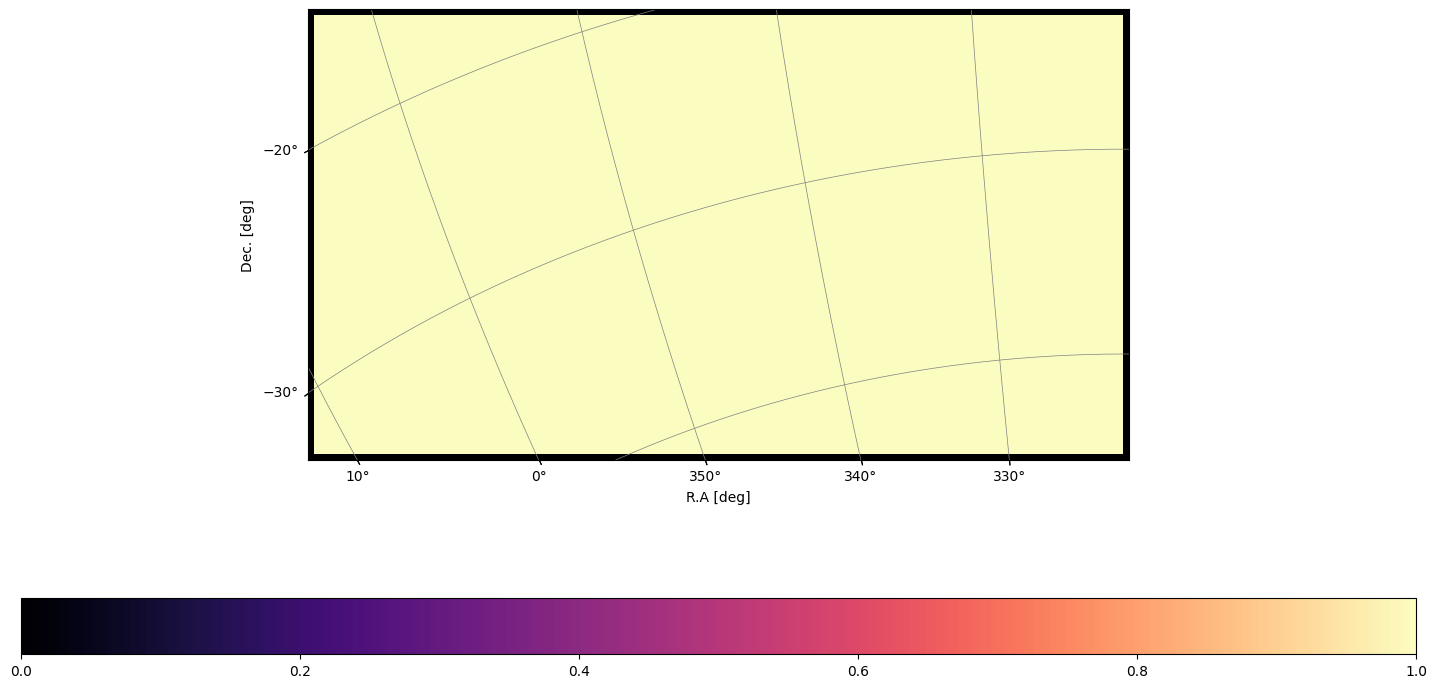

In [4]:
plot_map(sp.W_HI,sp.wproj)

Note that, the area specified by `wproj` is typically larger than the actual area as a buffer. For example, if you put in the actual survey range for MeerKLASS L-band, `meer21cm` will recognise and create a survey selection function automatically. For praticatical purposes, the edge of the `wproj` area is always set to `False` as shown above. If you put in a specific range:


In [5]:
raminMK,ramaxMK = 334,357
decminMK,decmaxMK = -35,-26.5
ra_range = (raminMK,ramaxMK)
dec_range = (decminMK,decmaxMK)
sp = Specification(
    ra_range=ra_range,
    dec_range=dec_range,
)

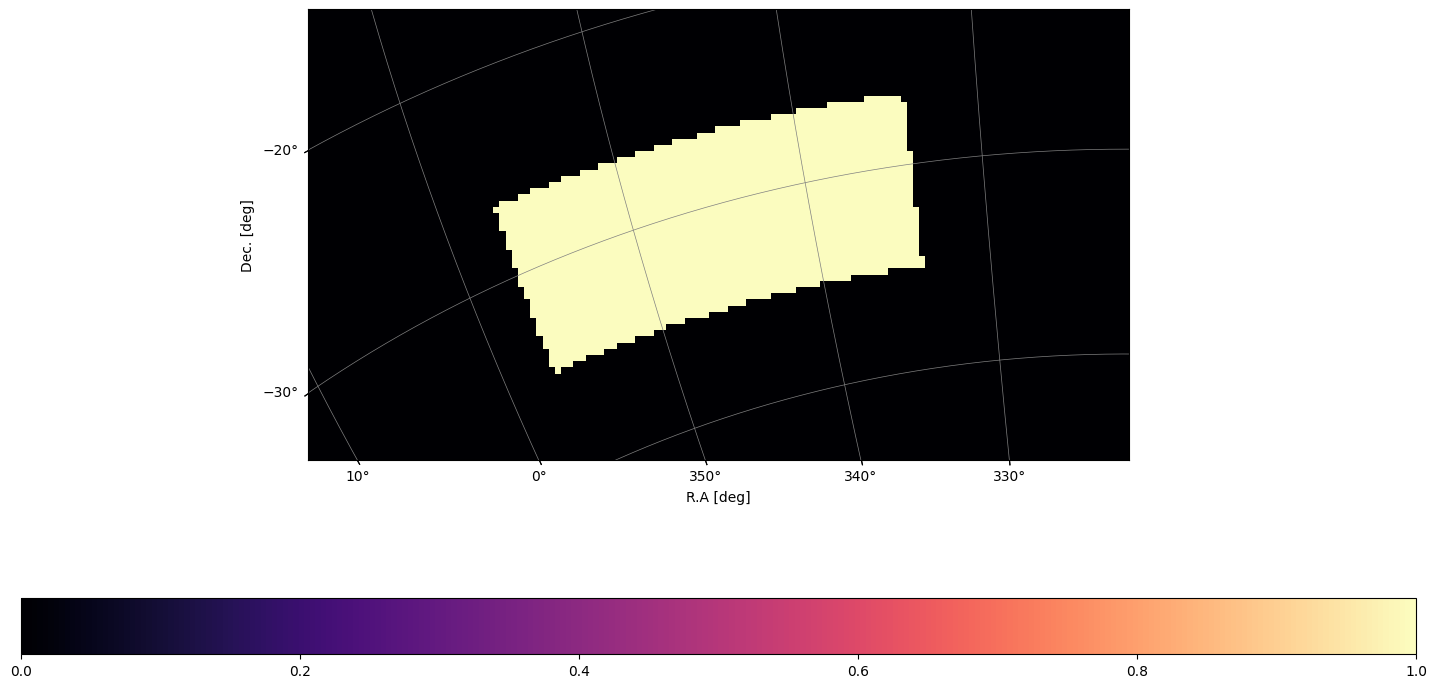

In [6]:
plot_map(sp.W_HI,sp.wproj)

You can see that the selection function is automatically updated.

## Custom redshift bin

Customising the redshift range is easy by simply setting custom frequency channels. Note that however, `meer21cm` **does not** support equally spaced redshift channeles, and **assumes** that frequency channels are equally spaced. This should be the case for any radio survey.

Suppose you want approximately z=0.5-1.0, with a frequency resolution of 1MHz:

In [7]:
z_min = 0.5
z_max = 1.0
freq_resol = 1e6
num_ch = int((redshift_to_freq(z_min)-redshift_to_freq(z_max))/freq_resol)
nu = np.linspace(0,num_ch-1,num_ch) * freq_resol + redshift_to_freq(z_max)

In [8]:
sp = Specification(
    nu = nu
)

In [9]:
sp.z_ch.min(),sp.z_ch.max(),sp.freq_resol,sp.survey_volume,sp.los_resol_in_mpc

(0.5027522535193767, 1.0, 1000000.0, 2692140666.7431483, 6.101602897145838)

The area will still be the default:

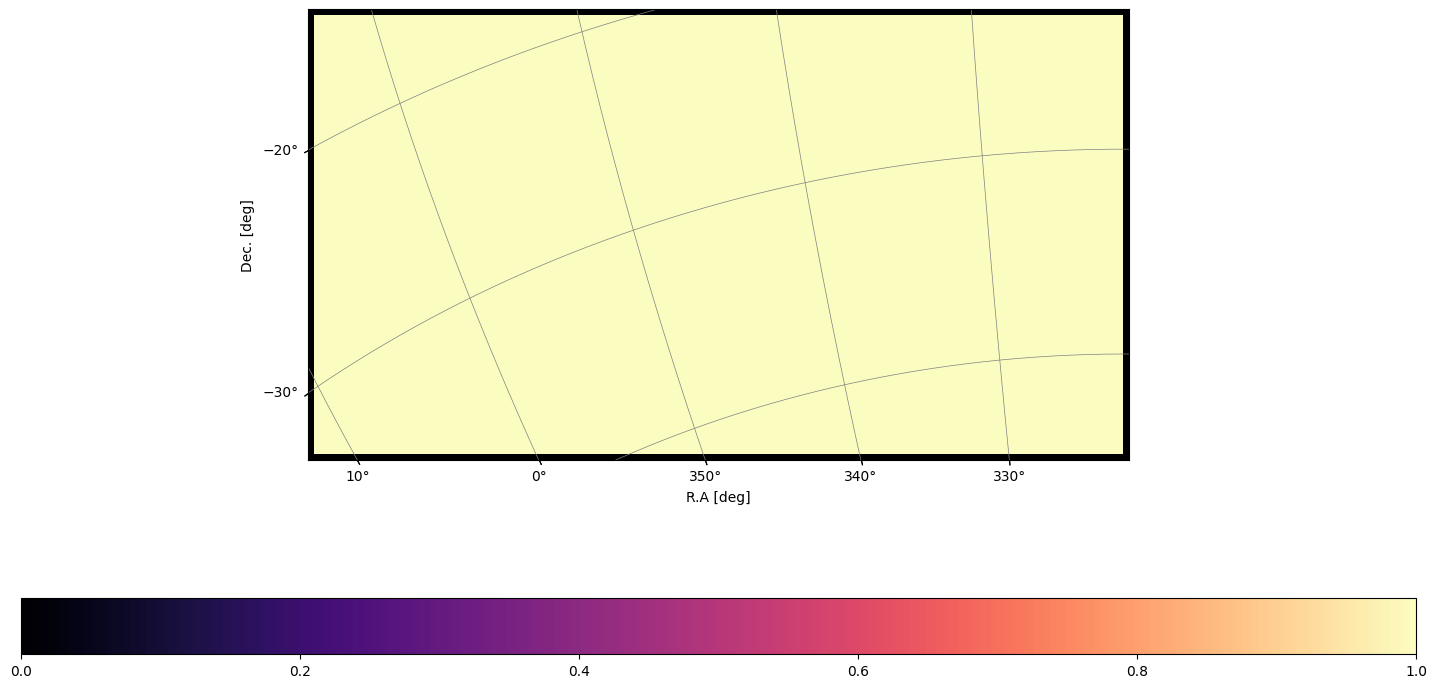

In [10]:
plot_map(sp.W_HI,sp.wproj)

## Custom survey area

Custom survey area is a little bit more complicated. `meer21cm` uses `astropy.wcs.WCS` for mapping the pixels to the sky coordinates. It relies on two ingredients: the `wcs` for projection, and `(num_pix_x, num_pix_y)` for array dimensions.


If you already have an actual data stored in a fits file, the best way to do this is to extract from that:

In [11]:
map_file = data_dir + "test_fits.fits"
wcs = WCS(map_file)
# extract the 2D array dimensions
num_pix_x,num_pix_y, _= wcs.array_shape
# you need to drop the axes that are not angular
wproj = wcs.dropaxis(-1)

In [12]:
sp = Specification(
    wproj=wproj,
    num_pix_x=num_pix_x,
    num_pix_y=num_pix_y,
)

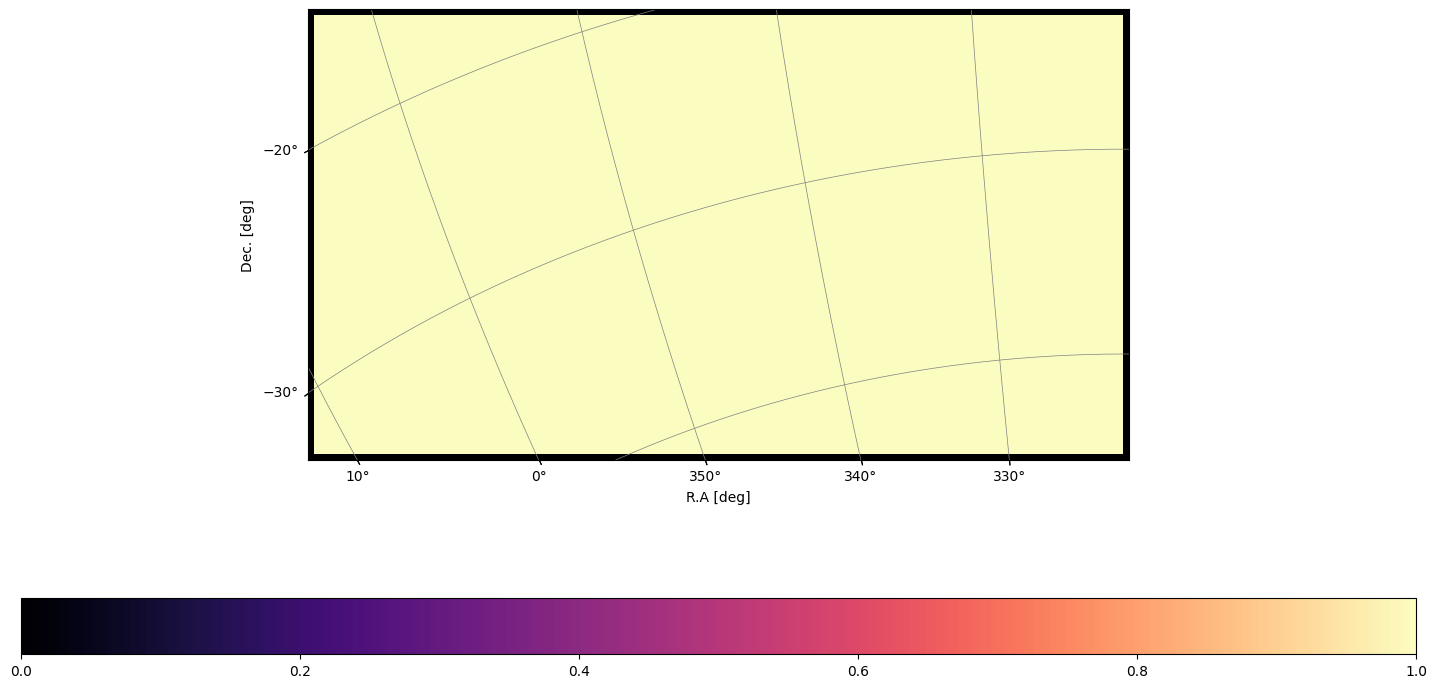

In [13]:
plot_map(sp.W_HI,sp.wproj)

If you are starting from scratch, you can use `create_wcs_with_range`. It needs `ra_range`, `dec_range`, angular resolution, and coordinate type as input (see documentation for more details). Let's say we are making a roughly 20x20 deg^2 area with 0.5 deg resolution:

In [14]:
ramincustom,ramaxcustom = -10,10
decmincustom,decmaxcustom = -10,10
ra_range = (ramincustom,ramaxcustom)
dec_range = (decmincustom,decmaxcustom)
ang_resol = 0.5
wproj,num_pix_x,num_pix_y = create_wcs_with_range(
    ra_range,
    dec_range,
    resol=[ang_resol,ang_resol],
)

sp = Specification(
    wproj=wproj,
    num_pix_x=num_pix_x,
    num_pix_y=num_pix_y,
    ra_range=ra_range,
    dec_range=dec_range,
)

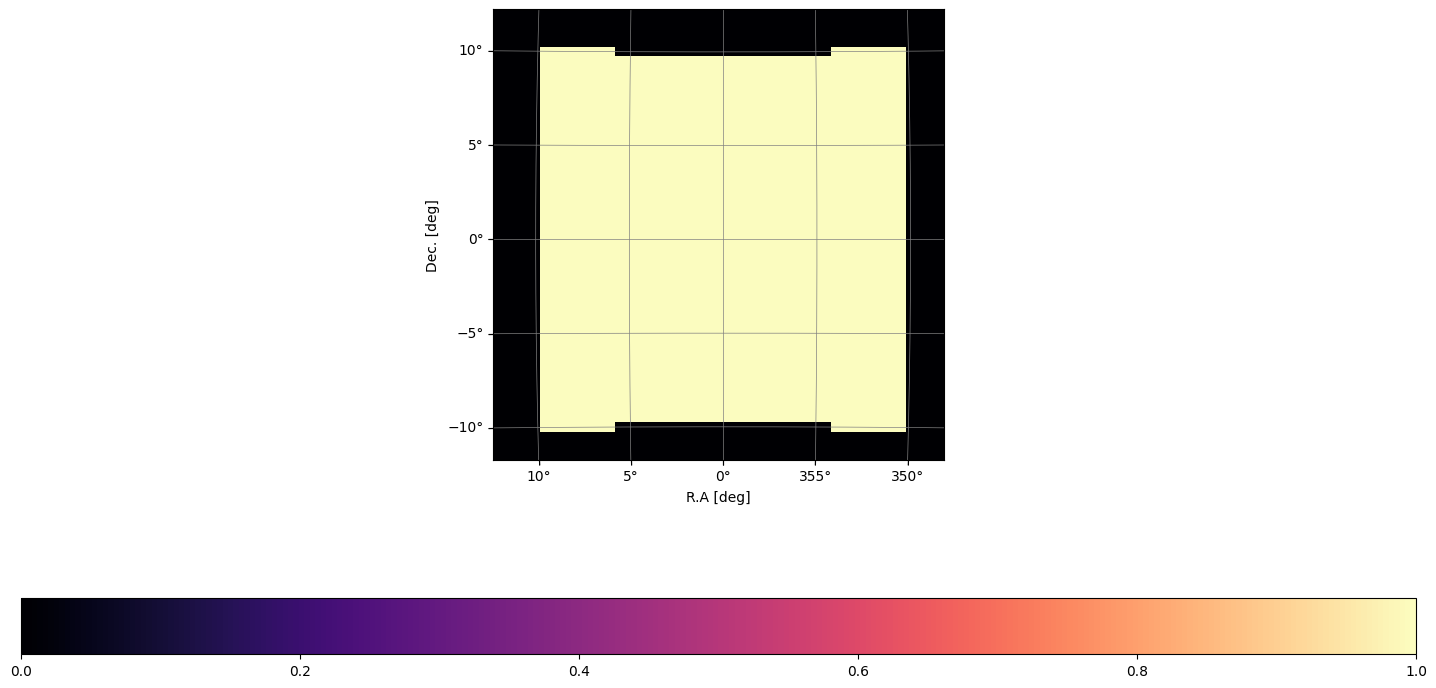

In [15]:
plot_map(sp.W_HI,sp.wproj)

The `wcs` always leave a bit more empty space as buffer. Note that, in some extreme cases, the default buffer `[1.2,1.2]` may not be enough to cover the range:

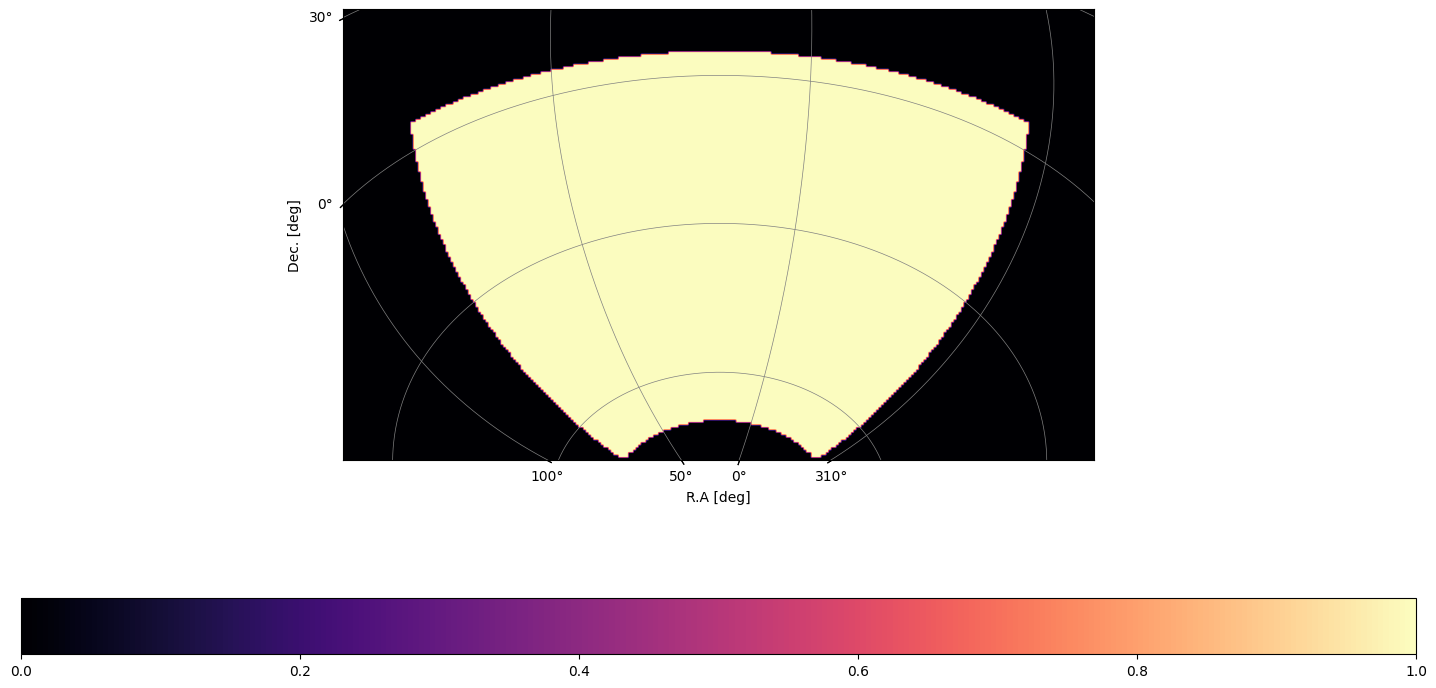

In [16]:
# note that (315,80) is different from (80,315)
ramincustom,ramaxcustom = 315,80
decmincustom,decmaxcustom = -70,5
ra_range = (ramincustom,ramaxcustom)
dec_range = (decmincustom,decmaxcustom)
ang_resol = 0.5
wproj,num_pix_x,num_pix_y = create_wcs_with_range(
    ra_range,
    dec_range,
    resol=[ang_resol,ang_resol],
)

sp = Specification(
    wproj=wproj,
    num_pix_x=num_pix_x,
    num_pix_y=num_pix_y,
    ra_range=ra_range,
    dec_range=dec_range,
)
plot_map(sp.W_HI,sp.wproj)

You should therefore always examine this and change if needed:

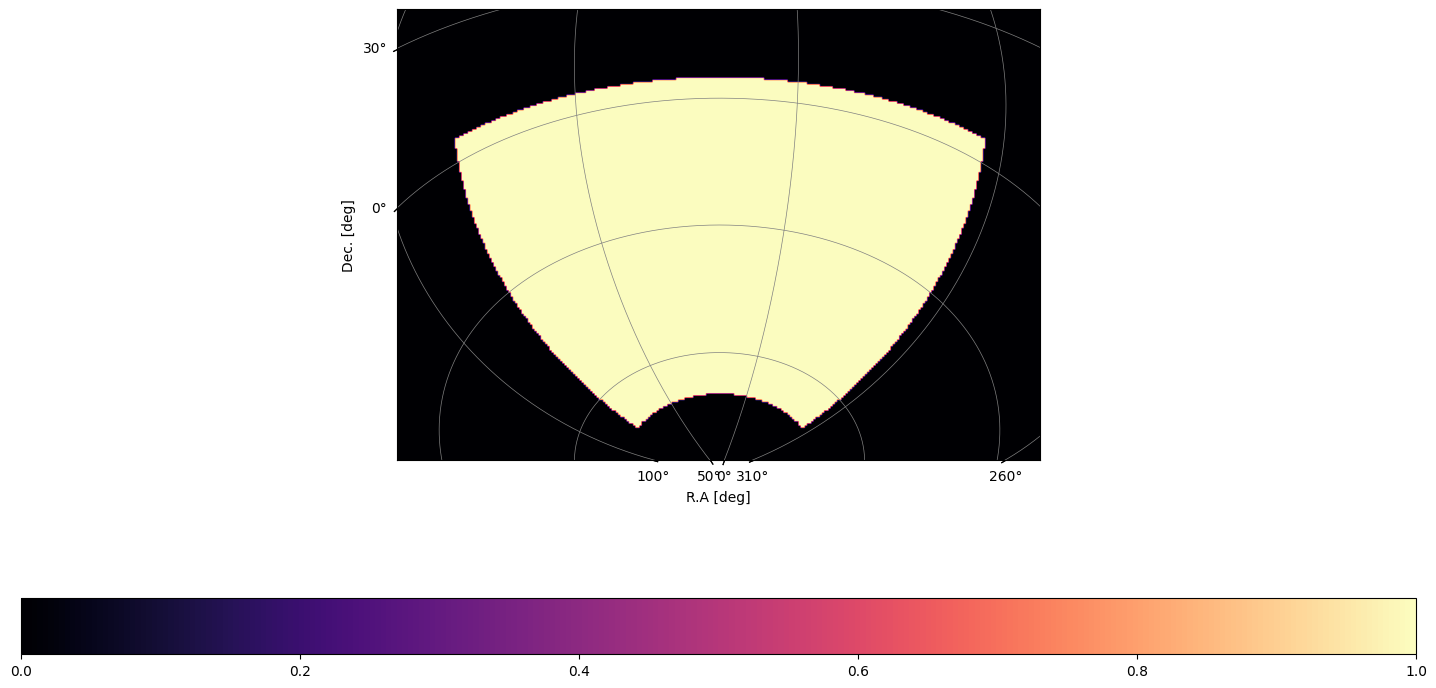

In [17]:
wproj,num_pix_x,num_pix_y = create_wcs_with_range(
    ra_range,
    dec_range,
    resol=[ang_resol,ang_resol],
    buffer=[1.2,1.4],
)

sp = Specification(
    wproj=wproj,
    num_pix_x=num_pix_x,
    num_pix_y=num_pix_y,
    ra_range=ra_range,
    dec_range=dec_range,
)
plot_map(sp.W_HI,sp.wproj)

An example to generate a mock observation with custom specs:

In [18]:
ramincustom,ramaxcustom = -10,10
decmincustom,decmaxcustom = -10,10
ra_range = (ramincustom,ramaxcustom)
dec_range = (decmincustom,decmaxcustom)
ang_resol = 0.5
wproj,num_pix_x,num_pix_y = create_wcs_with_range(
    ra_range,
    dec_range,
    resol=[ang_resol,ang_resol],
)

mock = MockSimulation(
    nu=nu,
    wproj=wproj,
    num_pix_x=num_pix_x,
    num_pix_y=num_pix_y,
    ra_range=ra_range,
    dec_range=dec_range,
    tracer_bias_1=1.5,
    tracer_bias_2=1.5,
    num_discrete_source=10000,
    mean_amp_1='average_hi_temp',
    downres_factor_radial = 1/2.0,
    downres_factor_transverse = 1/2.0,
    
)

Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False
Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False


/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:169: RuntimeWarning: invalid value encountered in multiply
  return results * val


In [19]:
mock.data = mock.propagate_mock_field_to_data(mock.mock_tracer_field_1)
mock.propagate_mock_tracer_to_gal_cat()

Note: redshifts have been re-sorted (earliest first)


/Users/zhaotingchen/Desktop/work/meer21cm/src/meer21cm/mock.py:381: UserWarning: Not enough tracers inside the ra, dec, z range. Try increasing target_relative_to_num_g.
  warnings.warn(


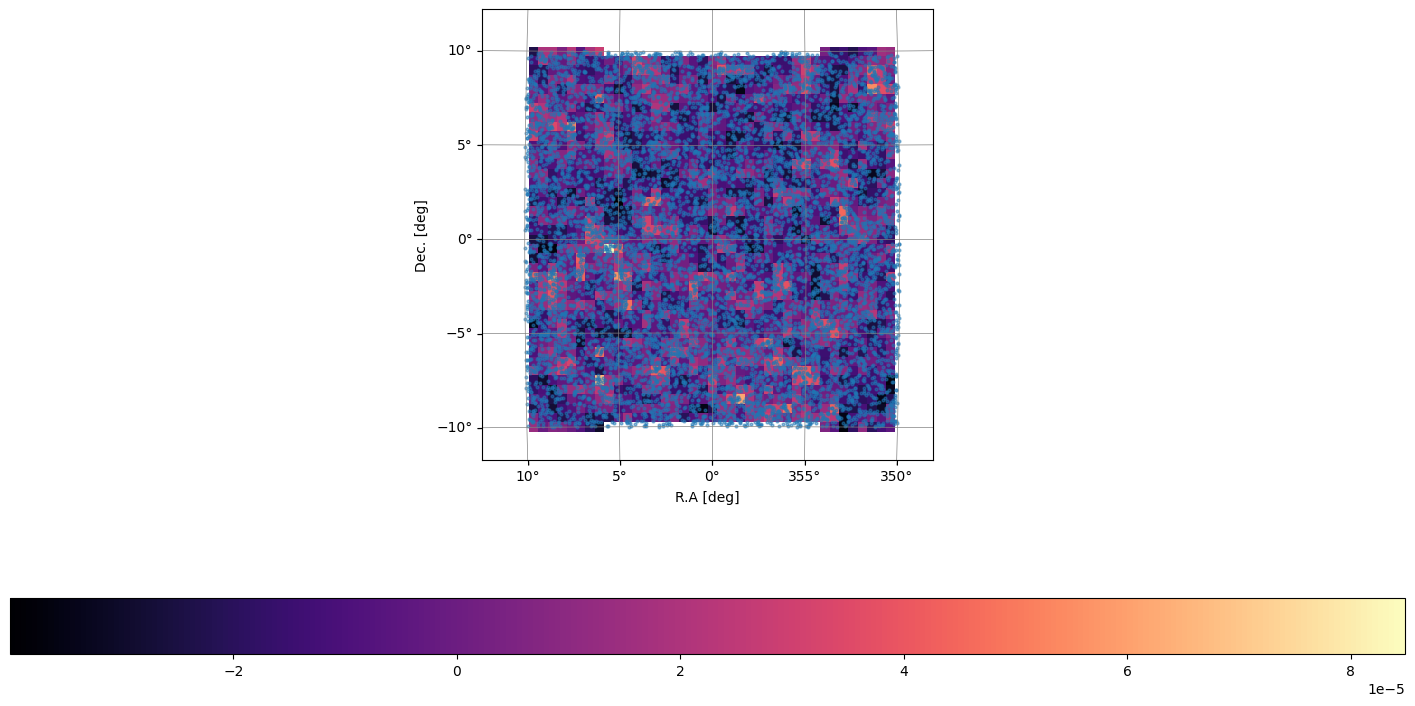

In [20]:
plot_map(mock.data,mock.wproj,W=mock.W_HI)
ax = plt.gca()
plt.scatter(
    mock.ra_gal,
    mock.dec_gal,
    transform=ax.get_transform('world'),s=4,label='mock tracers',alpha=0.5
)

TODO: noise, foregrounds and systematics